# Adversarial Benchmarking

This notebook includes the code to benchmark supervised and unsupervised ViTs against different adversarial attacks.

#### Install, Paths and Parameters

In [1]:
import os
from pathlib import Path
import getpass
import numpy as np
import time
import torch
from torch import nn
from tqdm import tqdm
import random
import sys
from torch.utils.data import DataLoader

# allow imports when running script from within project dir
[sys.path.append(i) for i in ['.', '..']]

# local
from src.helpers.helpers import get_random_indexes, get_random_classes
from src.model.dino_model import get_dino, ViTWrapper
from src.model.train import validate_network
from src.model.data import *

# Custom imports
import torchattacks
from torchattacks import *
import torch.optim as optim
from torchvision import transforms as pth_transforms

# seed
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

username = getpass.getuser()
DATA_PATH = Path('/cluster/scratch/thobauma/data/ori/')

ORI_PATH = Path(DATA_PATH, 'validation')
ORI_LABEL_PATH = Path(ORI_PATH,'labels.csv')
ORI_IMAGES_PATH = Path(ORI_PATH,'images')

In [2]:
INDEX_SUBSET = get_random_indexes(n_samples=3000) # Randomly sample data

BATCH_SIZE = 30
NUM_WORKERS= 0
PIN_MEMORY=True

DEVICE = 'cuda'

In [3]:
len(INDEX_SUBSET)

3000

## Load data

In [5]:
dataset = AdvTrainingImageDataset(ORI_IMAGES_PATH, ORI_LABEL_PATH, ORIGINAL_TRANSFORM, index_subset=INDEX_SUBSET, return_reduced=False)
loader = DataLoader(dataset, batch_size=50, pin_memory=True, shuffle=True)

# Evaluate DINO ViT

#### Load model

In [6]:
def get_dino_small():
    model_small, linear_classifier_small = get_dino(model_name='vit_small', patch_size=16, n_last_blocks=4, avgpool_patchtokens=False, device='cpu')
    dino_small = ViTWrapper(model_small, linear_classifier_small, device='cpu', n_last_blocks=4, avgpool_patchtokens=False)
    return dino_small

def get_dino_base():
    model_base, linear_classifier_base = get_dino(model_name='vit_base', patch_size=16, n_last_blocks=1, avgpool_patchtokens=True, device='cpu')
    dino_base = ViTWrapper(model_base, linear_classifier_base, device='cpu', n_last_blocks=1, avgpool_patchtokens=True)
    return dino_base

#### Wrap models

In [8]:
#### DINO ViT/B-16
dino_base = get_dino_base()

#### DINO ViT/S-16
dino_small = get_dino_small()

Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_base built.
Embed dim 1536
We load the reference pretrained linear weights from dino_vitbase16_pretrain/dino_vitbase16_linearweights.pth.
Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.
Model vit_small built.
Embed dim 1536
We load the reference pretrained linear weights from dino_deitsmall16_pretrain/dino_deitsmall16_linearweights.pth.


## Compute clean accuracy

In [9]:
def evaluate_dino(model_wrap, loader):
    clean_correct = 0
    total = len(loader.dataset)
    start = time.time()
    model_wrap.cuda()

    with torch.no_grad():
        for images, labels, _ in tqdm(loader):

            cuda_images = images.to(DEVICE)
            clean_outputs = model_wrap(cuda_images)
            labels = labels.to(DEVICE)

            _, pre_clean = torch.max(clean_outputs.data, 1)

            clean_correct += (pre_clean == labels).sum()

    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Clean accuracy: %.2f %%' % (100 * float(clean_correct) / total))
    model_wrap.cpu()
    return clean_correct

In [10]:
evaluate_dino(dino_small, loader)

100%|██████████| 60/60 [00:54<00:00,  1.10it/s]

Total elapsed time (sec): 54.60
Clean accuracy: 78.47 %


tensor(2354, device='cuda:0')

In [11]:
evaluate_dino(dino_base, loader)

100%|██████████| 60/60 [00:39<00:00,  1.51it/s]

Total elapsed time (sec): 39.90
Clean accuracy: 78.87 %


tensor(2366, device='cuda:0')

In [12]:
torch.cuda.empty_cache()

## Attack model
We use TorchAttack library. See: https://github.com/Harry24k/adversarial-attacks-pytorch

In [22]:
# Define attacks to be tested

attacks = lambda x: [
    FGSM(x.cuda(), eps=0.001),
    FGSM(x.cuda(), eps=0.03),
    FGSM(x.cuda(), eps=0.1),
    PGD(x.cuda(), eps=0.001, alpha=(0.001*2)/3, steps=3),
    PGD(x.cuda(), eps=0.03, alpha=(0.03*2)/3, steps=3),
    PGD(x.cuda(), eps=0.1, alpha=(0.1*2)/3, steps=3),
    CW(x.cuda(), c=50),
]

In [23]:
dino_small_attacks = attacks(dino_small)
dino_base_attacks = attacks(dino_small)

In [24]:
def adversarial_accuracy(model, loader, attacks):
    for atk in attacks:
        total = len(loader.dataset)
        print("-"*70)
        print(atk)

        model.cuda()

        correct = 0
        clean_correct = 0
        start = time.time()

        for images, labels, _ in tqdm(loader):

            labels = labels.to(DEVICE)
            adv_images = atk(images.cuda(), labels)

            with torch.no_grad():
                outputs = model(adv_images.cuda())

            _, pre = torch.max(outputs.data, 1)

            correct += (pre == labels).sum()

            del images
            del labels
            del adv_images
            torch.cuda.empty_cache()

        print('Total elapsed time (sec): %.2f' % (time.time() - start))
        print('Accuracy against attack: %.2f %%' % (100 * float(correct) / total))
    
    model.cpu()

In [ ]:
adversarial_accuracy(dino_small, loader, dino_small_attacks)

  0%|          | 0/60 [00:00<?, ?it/s]

----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.001, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 55.14
Accuracy against attack: 52.03 %
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.03, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 51.38
Accuracy against attack: 1.30 %
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.1, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 50.98
Accuracy against attack: 1.13 %
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.001, alpha=0.0006666666666666666, steps=3, random_start=True, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 80.33
Accuracy against attack: 49.13 %
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.03, alpha=0.02, steps=3, random_start=True, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 79.78
Accuracy against attack: 0.00 %
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.1, alpha=0.06666666666666667, steps=3, random_start=True, attack_mode=default, return_type=float)


  0%|          | 0/60 [00:00<?, ?it/s]

Total elapsed time (sec): 78.98
Accuracy against attack: 0.00 %
----------------------------------------------------------------------
CW(model_name=ViTWrapper, device=cuda:0, c=50, kappa=0, steps=1000, lr=0.01, attack_mode=default, return_type=float)


 42%|████▏     | 25/60 [19:12<26:29, 45.40s/it]

In [ ]:
adversarial_accuracy(dino_base, loader, dino_base_attacks)

# Evaluate Original ViT

#### Load model

We use pretrained model from: https://github.com/lukemelas/PyTorch-Pretrained-ViT

In [ ]:
from PIL import Image
import torch
from torchvision import transforms
from pytorch_pretrained_vit import ViT

class CustomViT(ViT):
    def __init__(self):
        super().__init__('B_16_imagenet1k', pretrained=True)
        self.transform = transforms.Compose([
    transforms.Normalize(0.5, 0.5),
])
        
    def __call__(self, x):
        x = self.transform(x)
        return self.forward(x)

In [ ]:
def get_supervised_vit():
    sup_vit = CustomViT().to('cpu').eval()
    return sup_vit

#### Load data

In [ ]:
sup_dataset = AdvTrainingImageDataset(ORI_IMAGES_PATH, ORI_LABEL_PATH, transforms.Compose([
    transforms.Resize((384, 384)), 
    transforms.ToTensor(),
]), index_subset=INDEX_SUBSET, return_reduced=False)
sup_loader = DataLoader(sup_dataset, batch_size=10, pin_memory=True, shuffle=True)

#### Compute clean accuracy

In [ ]:
def evaluate_supervised_vit(sup_vit, loader):
    sup_vit.cuda()
    clean_correct = 0
    total = len(loader.dataset)
    start = time.time()

    with torch.no_grad():
        for images, labels, _ in tqdm(loader):

            cuda_images = images.to(DEVICE)
            clean_outputs = sup_vit(cuda_images)
            labels = labels.to(DEVICE)

            _, pre_clean = torch.max(clean_outputs.data, 1)

            clean_correct += (pre_clean == labels).sum()

    sup_vit.cpu()
    print('Total elapsed time (sec): %.2f' % (time.time() - start))
    print('Clean accuracy: %.2f %%' % (100 * float(clean_correct) / total))
    return clean_correct

In [ ]:
evaluate_supervised_vit(sup_vit, sup_loader)

#### Attack model

In [ ]:
sup_vit_attacks = attacks(sup_vit)

In [ ]:
adversarial_accuracy(sup_vit, sup_loader, sup_vit_attacks)

# Visualize images

In this section we visualize images used for the report.

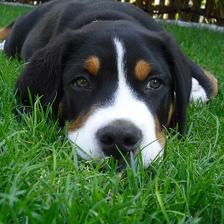

In [5]:
from PIL import Image
Image.open(Path(ORI_IMAGES_PATH, 'ILSVRC2012_val_00000013.JPEG'))

In [10]:
import matplotlib.pyplot as plt

def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [107]:
vis_dataset = AdvTrainingImageDataset(ORI_IMAGES_PATH, ORI_LABEL_PATH, ORIGINAL_TRANSFORM, index_subset=[2])
vis_loader = DataLoader(vis_dataset, batch_size=1, pin_memory=True, shuffle=True)

  0%|          | 0/1 [00:00<?, ?it/s]

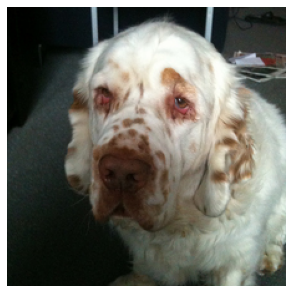

100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

tensor([0], device='cuda:0')
tensor([0])


In [108]:
for images, labels, img_names in tqdm(vis_loader):
    imshow(images[0].detach().cpu(), "")
    with torch.no_grad():
        outputs = model_wrap(images.cuda())
        _, pre = torch.max(outputs.data, 1)
        print(pre)
        print(labels)

In [109]:
attacks = [
    PGD(model_wrap, eps=0.001, alpha=(0.001*2)/3, steps=3),
    PGD(model_wrap, eps=0.03, alpha=(0.03*2)/3, steps=3),
    PGD(model_wrap, eps=0.1, alpha=(0.1*2)/3, steps=3),
    FGSM(model_wrap, eps=0.001),
    FGSM(model_wrap, eps=0.03),
    FGSM(model_wrap, eps=0.1),
    CW(model_wrap, c=50)
]

  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.003, alpha=0.002, steps=3, random_start=True, attack_mode=default, return_type=float)


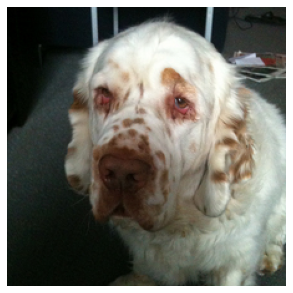

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True | Predicted class: tensor([3], device='cuda:0') | True class: tensor([0], device='cuda:0')
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.03, alpha=0.02, steps=3, random_start=True, attack_mode=default, return_type=float)


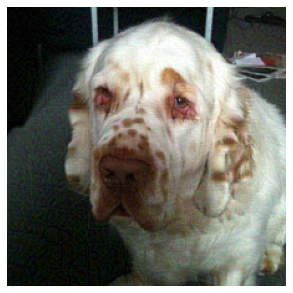

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True | Predicted class: tensor([2], device='cuda:0') | True class: tensor([0], device='cuda:0')
----------------------------------------------------------------------
PGD(model_name=ViTWrapper, device=cuda:0, eps=0.06, alpha=0.06666666666666667, steps=3, random_start=True, attack_mode=default, return_type=float)


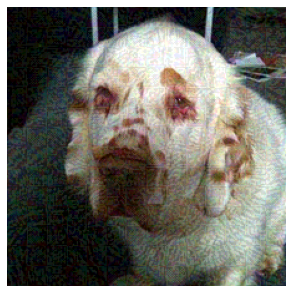

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True | Predicted class: tensor([2], device='cuda:0') | True class: tensor([0], device='cuda:0')
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.003, attack_mode=default, return_type=float)


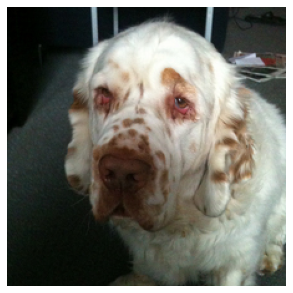

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True | Predicted class: tensor([2], device='cuda:0') | True class: tensor([0], device='cuda:0')
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.03, attack_mode=default, return_type=float)


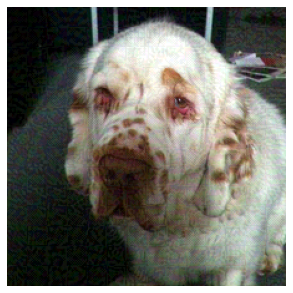

  0%|          | 0/1 [00:00<?, ?it/s]

Is adversarial? True | Predicted class: tensor([2], device='cuda:0') | True class: tensor([0], device='cuda:0')
----------------------------------------------------------------------
FGSM(model_name=ViTWrapper, device=cuda:0, eps=0.06, attack_mode=default, return_type=float)


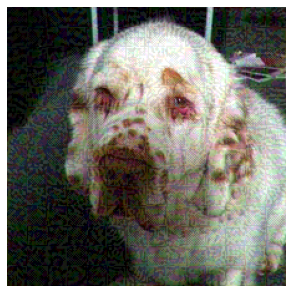

100%|██████████| 1/1 [00:00<00:00,  5.18it/s]

Is adversarial? True | Predicted class: tensor([2], device='cuda:0') | True class: tensor([0], device='cuda:0')


  0%|          | 0/1 [00:00<?, ?it/s]

----------------------------------------------------------------------
CW(model_name=ViTWrapper, device=cuda:0, c=50, kappa=0, steps=1000, lr=0.01, attack_mode=default, return_type=float)


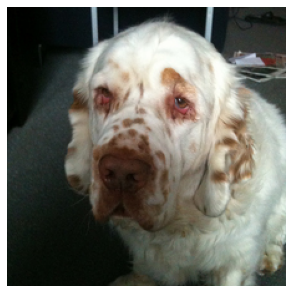

100%|██████████| 1/1 [00:04<00:00,  4.47s/it]

Is adversarial? False | Predicted class: tensor([0], device='cuda:0') | True class: tensor([0], device='cuda:0')


In [110]:
for atk in attacks:
    
    print("-"*70)

    correct = 0
    clean_correct = 0
    start = time.time()
    print(atk)
    
    for images, labels, img_names in tqdm(vis_loader):
        
        labels = labels.to(DEVICE)
        adv_images = atk(images, labels)
        
        with torch.no_grad():
            outputs = model_wrap(adv_images)

        _, pre = torch.max(outputs.data, 1)

        correct += (pre == labels).sum()
        
        imshow(adv_images[0].detach().cpu(), "")
        
        print(f"Is adversarial? {correct==0} | Predicted class: {pre} | True class: {labels}")